In [ ]:
#Import all necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model

# try:
#     from torchmetrics import Accuracy
# except:
#     !pip install torchmetrics
#     from torchmetrics import Accuracy

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import time
from tqdm import tqdm
import csv
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sb
import textwrap
import warnings
warnings.filterwarnings("ignore")

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
#Select GPU as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

if device.type =='cuda':
  print(torch.cuda.get_device_name(device))

Selected device: cuda
Tesla V100-SXM2-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD'
file_dir = '/content/SAM-DD/'


#Upload train data folder to google colab files directory
if not os.path.exists(file_dir):
  os.makedirs(file_dir)
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'SAM-DD(train).zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
class_dict = {0 : "safe driving",
              1 : "drinking",
              2 : "talking on the phone - left",
              3 : "talking on the phone - right",
              4 : "texting - left",
              5 : "texting - right",
              6 : "Doing hair",
              7 : "Adjusting specs",
              8 : "Reaching behind",
              9 : "Sleeping"}

In [ ]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("PairedDriverDataset", "/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/TwoStreamPairedDataset.py")
paired_driver_dataset_module  = importlib.util.module_from_spec(spec)
spec.loader.exec_module(paired_driver_dataset_module)
PairedDriverDataset = paired_driver_dataset_module.PairedDriverDataset


In [ ]:
# # Directories
# test_dir = "/content/SAM-DD/SAM-DD(train)/Tester/front_RGB"
# val_dir = "/content/SAM-DD/SAM-DD(train)/Val/front_RGB"

# # Get classes and sort them
# classes = [c for c in os.listdir(test_dir) if not c.startswith(".")]
# classes.sort()

# # Count the number of files in each class for both test and validation directories
# test_counts = []
# val_counts = []

# for cls in classes:
#     test_class_dir = os.path.join(test_dir, cls)
#     val_class_dir = os.path.join(val_dir, cls)

#     # Count files, ignoring hidden files
#     test_files = [f for f in os.listdir(test_class_dir) if not f.startswith(".")]
#     val_files = [f for f in os.listdir(val_class_dir) if not f.startswith(".")]

#     test_counts.append(len(test_files))
#     val_counts.append(len(val_files))

# # Create a DataFrame for plotting
# data = pd.DataFrame({
#     'Class': classes * 2,  # Repeat 'classes' twice because we have two sets of counts
#     'Counts': test_counts + val_counts,  # Concatenate counts
#     'Dataset': ['Test'] * len(test_counts) + ['Validation'] * len(val_counts)  # Label the counts
# })

# # Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(10, 6))

# # Set the color palette to "Set2"
# sb.set_palette("Set2")

# # Plot the counts for each class and dataset
# sb.barplot(x="Class", y="Counts", hue="Dataset", data=data, ax=ax)

# # Customize the plot
# ax.set_title('Class Distribution')
# ax.set_ylabel('Counts')
# ax.set_xlabel('Class')
# plt.xticks(rotation=45, ha='right')  # Rotate class labels for better readability

# # Show plot
# plt.tight_layout()
# plt.show()


In [ ]:
front_view_dir = "/content/SAM-DD/SAM-DD(train)/Val/front_RGB"
side_view_dir = "/content/SAM-DD/SAM-DD(train)/Val/side_RGB"

# Instantiate the dataset
data = PairedDriverDataset(
    front_dir = front_view_dir,
    side_dir = side_view_dir,
)

print(len(data))
valid_size = int(0.2*len(data))
test_size = int(0.1*len(data))
train_size = len(data)-valid_size-test_size

train_data, valid_data, test_data = random_split(data, [train_size, valid_size, test_size])
print(len(train_data), len(valid_data), len(test_data))

14336
10036 2867 1433


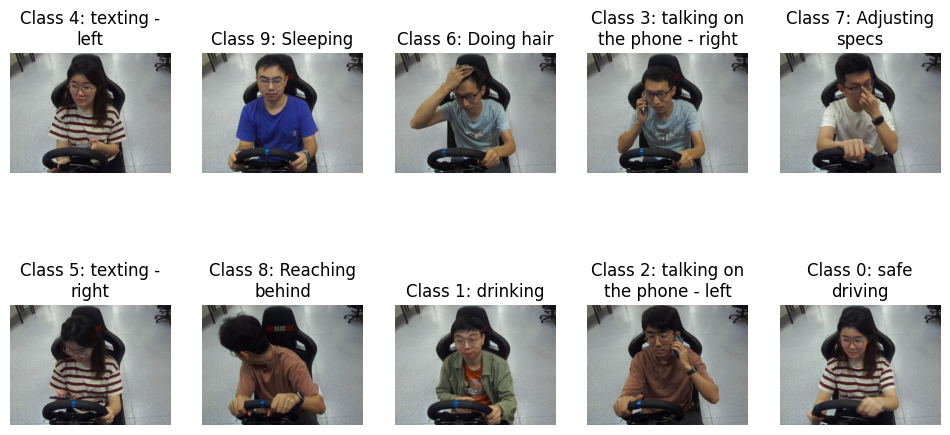

In [ ]:
torch.manual_seed(42)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
classes = [c for c in os.listdir(front_view_dir) if not c.startswith(".")]
classes.sort()
for i, class_name in enumerate(os.listdir(front_view_dir)):
  class_idx = classes.index(class_name)
  class_path = os.path.join(front_view_dir, class_name)
  images = [img for img in os.listdir(class_path)]
  random_index = np.random.randint(len(images))
  image_path = os.path.join(class_path, images[random_index])
  image = mpimg.imread(image_path)


  row = i // 5  # Determine the row in the grid
  col = i % 5   # Determine the column in the grid
  ax = axs[row, col]  # Select the current subplot
  ax.imshow(image)
  ax.axis('off')
 # Wrap the title text
  title_text = f'Class {class_name}: {class_dict[class_idx]}'
  wrapped_text = textwrap.fill(title_text, width=20)  # Adjust 'width' as needed
  ax.set_title(wrapped_text, fontdict={'fontsize': 12, 'fontweight': 'medium'})

In [ ]:
classes = [c for c in os.listdir(front_view_dir) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Total number of  data : 14336


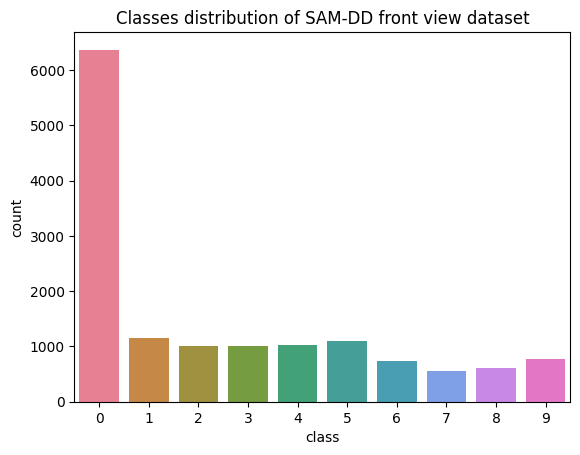

In [ ]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(front_view_dir,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of SAM-DD front view dataset")
print("Total number of  data :",len(df))

In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (244,244)

color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
rotation = transforms.RandomRotation(15)
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
translation = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))


data_transforms = {
    'train_front': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),

    'train_side': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([translation], p=0.5),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}

In [ ]:
class TransformDataset(Dataset):
    def __init__(self, dataset, front_transform=None, side_transform=None):
        self.dataset = dataset
        self.front_transform = front_transform
        self.side_transform = side_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        front_image, side_image, label = self.dataset[idx]
        if self.front_transform:
            front_image = self.front_transform(front_image)
        if self.side_transform:
            side_image = self.side_transform(side_image)
        return front_image, side_image, label

In [ ]:
train_data = TransformDataset(train_data, front_transform=data_transforms['train_front'], side_transform = data_transforms['train_side'])
valid_data = TransformDataset(valid_data, front_transform=data_transforms['valid'], side_transform=data_transforms['valid'])
test_data = TransformDataset(test_data, front_transform=data_transforms['test'], side_transform=data_transforms['test'])

In [ ]:
num_pairs = 20
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))

for i in range(num_pairs):
  idx = np.random.randint(0, len(train_data))  # Random index
  front_image, side_image, class_idx = train_data[idx]  # Fetch images and class index

  # Convert tensors back to PIL images for display purposes
  # Skip these lines if your transform does not convert images to tensors
  front_image = transforms.ToPILImage()(front_image)
  side_image = transforms.ToPILImage()(side_image)

  class_name = class_dict[class_idx]

  # Plot front image
  axs[i, 0].imshow(front_image)
  axs[i, 0].set_title(f"Front View {i}: {class_name}")
  axs[i, 0].axis('off')

  # Plot side image
  axs[i, 1].imshow(side_image)
  axs[i, 1].set_title(f"Side View {i}: {class_name}")
  axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size = 16

#Create a data loader with batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print(f"Number of images in the train dataset: {len(train_loader.dataset)}")
print(f"Number of images in the valid dataset: {len(valid_loader.dataset)}")
print(f"Number of images in the test dataset: {len(test_loader.dataset)}")

Number of images in the train dataset: 10036
Number of images in the valid dataset: 2867
Number of images in the test dataset: 1433


In [ ]:
train_front_batch, train_side_batch, train_labels_batch = next(iter(train_loader))
train_front_batch.shape, train_side_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 244, 244]),
 torch.Size([16, 3, 244, 244]),
 torch.Size([16]))

In [ ]:
front_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3l_front(unfreeze)/'
side_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3_side/'

model_path1 = os.path.join(front_folder_path, 'my_checkpoint.pth.tar')
model_path2 = os.path.join(side_folder_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    front_checkpoint = torch.load(model_path1)
    side_checkpoint = torch.load(model_path2)


In [ ]:
spec = importlib.util.spec_from_file_location("TwoStreamMobileNetV3L", "/content/drive/MyDrive/DAR_Deep Learning Model/TwoStreamMobileNetV3L.py")
TwoStreamMobileNetV3L = importlib.util.module_from_spec(spec)
sys.modules["TwoStreamMobileNetV3L"] = TwoStreamMobileNetV3L
spec.loader.exec_module(TwoStreamMobileNetV3L)

model = TwoStreamMobileNetV3L.TwoStreamMobileNetV3L(front_checkpoint, side_checkpoint)
model.to(device)

TwoStreamMobileNetV3L(
  (model1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [ ]:
summary(model=model,
        input_size=[(16, 3, 224, 224), (16, 3, 224, 224)],  # Corrected typo from 244 to 224
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TwoStreamMobileNetV3L (TwoStreamMobileNetV3L)                     [16, 3, 224, 224]    [16, 10]             --                   Partial
├─MobileNetV3 (model1)                                            --                   --                   1,242,890            False
│    └─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (2)                                  [16, 16, 112, 112]   [16, 24, 56, 56]     (3,440)              False
│    │    └─InvertedResidual (3)                 

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, threshold=0.01, threshold_mode='rel')

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

In [ ]:
early_stopping = EarlyStopping(patience=4, min_delta=0.005)

In [ ]:
class CSVLogger:
    def __init__(self, filename, fieldnames=['epoch','learning_rate', 'epoch_duration', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc']):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create file and write header
        with open(self.filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc):
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow({
                'epoch': epoch,
                'learning_rate': lr,
                'epoch_duration': epoch_duration,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'valid_loss': valid_loss,
                'valid_acc': valid_acc
            })

In [ ]:
log_path = os.path.join(folder_path,'training_log/2streammobilenetv3l')
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [ ]:
logger = CSVLogger(os.path.join(log_path,'training_log.csv'))

In [ ]:
cp_filename = os.path.join(log_path,'my_checkpoint.pth.tar')

def save_checkpoint(state, filename=cp_filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_acc = 0
    min_lr = 1e-7
    # Start the timer
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      #------- Training----------
      train_loss, train_acc = 0, 0
      model.train()
      for batch, (X1_train, X2_train, y_train) in enumerate(train_loader):
        model.train()
        # 1. Forward pass
        X1_train = X1_train.to(device)
        X2_train = X2_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()  # Reset gradients at the start of each epoch


        train_pred = model(X1_train, X2_train)
        loss = criterion(train_pred, y_train)
        train_loss +=loss

        # 4. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))
        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X1_train)}/{len(train_loader.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_loader)

      epoch_duration = time.time()-since
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      valid_loss = 0
      valid_acc = 0
      model.eval()
      with torch.inference_mode():
        for X1_valid, X2_valid,  y_valid in valid_loader:
          # 1. Forward pass
          X1_valid = X1_valid.to(device)
          X2_valid = X2_valid.to(device)
          y_valid = y_valid.to(device)
          valid_pred = model(X1_valid, X2_valid)

          valid_loss += criterion(valid_pred, y_valid)

          # 3. Calculate accuracy (preds need to be same as y_true)
          valid_acc += accuracy_fn(y_true=y_valid, y_pred=valid_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

      # Model Checkpointing
      if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

      for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(lr)

      scheduler.step(valid_acc)

      for param_group in optimizer.param_groups:
          param_group['lr'] = max(param_group['lr'], min_lr)

      ## Print out what's happening
      print(f"\nEpoch duration: {epoch_duration:.0f}s, lr: {lr}, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Valid loss: {valid_loss:.2f}, Valid acc: {valid_acc:.2f}%\n")

      logger.log(epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc)


      early_stopping(valid_acc)
      if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("Finished Training")
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f}")
    return model, train_losses, train_accuracies,valid_losses, valid_accuracies



In [ ]:
model, train_losses, training_accs, valid_losses, valid_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples
=> Saving checkpoint


  2%|▏         | 1/50 [03:39<2:59:02, 219.24s/it]

0.001

Epoch duration: 179s, lr: 0.001, Train loss: 0.35791, Train acc: 91.99% | Valid loss: 0.09, Valid acc: 98.09%


Epoch: 1
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples
=> Saving checkpoint
0.001

Epoch duration: 178s, lr: 0.001, Train loss: 0.11452, Train acc: 97.35% | Valid loss: 0.06, Valid acc: 98.58%



  4%|▍         | 2/50 [07:18<2:55:14, 219.04s/it]


Epoch: 2
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples
=> Saving checkpoint
0.001

Epoch duration: 179s, lr: 0.001, Train loss: 0.09817, Train acc: 97.55% | Valid loss: 0.05, Valid acc: 98.75%



  6%|▌         | 3/50 [10:58<2:51:52, 219.42s/it]


Epoch: 3
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples


  8%|▊         | 4/50 [14:35<2:47:45, 218.81s/it]

0.001

Epoch duration: 177s, lr: 0.001, Train loss: 0.08489, Train acc: 97.86% | Valid loss: 0.05, Valid acc: 98.58%


Epoch: 4
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples
=> Saving checkpoint


 10%|█         | 5/50 [18:15<2:44:24, 219.21s/it]

0.0001

Epoch duration: 179s, lr: 0.0001, Train loss: 0.07464, Train acc: 98.00% | Valid loss: 0.05, Valid acc: 98.85%


Epoch: 5
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples
=> Saving checkpoint


 12%|█▏        | 6/50 [21:54<2:40:44, 219.20s/it]

0.0001

Epoch duration: 178s, lr: 0.0001, Train loss: 0.07487, Train acc: 98.03% | Valid loss: 0.05, Valid acc: 98.96%


Epoch: 6
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples


 14%|█▍        | 7/50 [25:34<2:37:13, 219.39s/it]

0.0001

Epoch duration: 179s, lr: 0.0001, Train loss: 0.07150, Train acc: 98.16% | Valid loss: 0.04, Valid acc: 98.85%


Epoch: 7
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples


 16%|█▌        | 8/50 [29:15<2:33:57, 219.95s/it]

1e-05

Epoch duration: 180s, lr: 1e-05, Train loss: 0.07276, Train acc: 98.11% | Valid loss: 0.05, Valid acc: 98.92%


Epoch: 8
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples


 18%|█▊        | 9/50 [32:54<2:30:00, 219.51s/it]

1e-05

Epoch duration: 178s, lr: 1e-05, Train loss: 0.07644, Train acc: 97.98% | Valid loss: 0.05, Valid acc: 98.92%


Epoch: 9
-------
Looked at 0/10036 samples
Looked at 1600/10036 samples
Looked at 3200/10036 samples
Looked at 4800/10036 samples
Looked at 6400/10036 samples
Looked at 8000/10036 samples
Looked at 9600/10036 samples


 18%|█▊        | 9/50 [36:34<2:46:35, 243.78s/it]

1e-05

Epoch duration: 179s, lr: 1e-05, Train loss: 0.07738, Train acc: 97.84% | Valid loss: 0.04, Valid acc: 98.89%

Early stopping triggered
Finished Training
Total training time: 2194.05


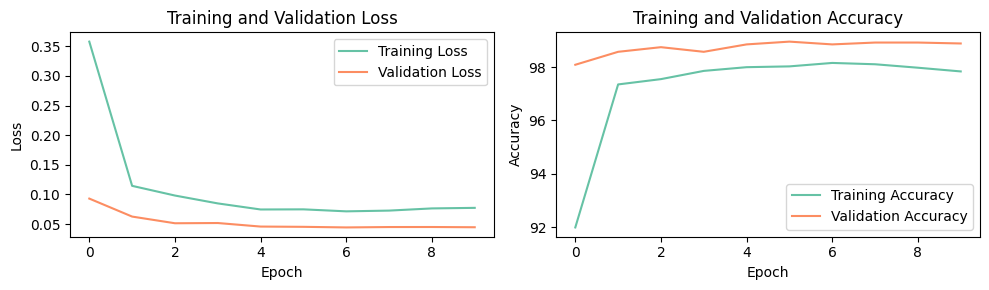

In [ ]:
training_losses_cpu = [loss.detach().cpu().numpy() for loss in train_losses]
valid_losses_cpu = [loss.detach().cpu().numpy() for loss in valid_losses]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(training_losses_cpu, label="Training Loss")
axes[0].plot(valid_losses_cpu, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(False)

axes[1].plot(training_accs, label="Training Accuracy")
axes[1].plot(valid_accs, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


In [ ]:
model = None

if model == None:
  model = TwoStreamMobileNetV3L.TwoStreamMobileNetV3L(front_checkpoint, side_checkpoint)


checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

for param in model.classifier.parameters():
    param.requires_grad = False

# Load the model state
model.load_state_dict(checkpoint['state_dict'])



# Move the model to the device
model.to(device)

TwoStreamMobileNetV3L(
  (model1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [ ]:
summary(model=model,
        input_size=[(16, 3, 224, 224), (16, 3, 224, 224)],  # Corrected typo from 244 to 224
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TwoStreamMobileNetV3L (TwoStreamMobileNetV3L)                     [16, 3, 224, 224]    [16, 10]             --                   False
├─MobileNetV3 (model1)                                            --                   --                   1,242,890            False
│    └─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (2)                                  [16, 16, 112, 112]   [16, 24, 56, 56]     (3,440)              False
│    │    └─InvertedResidual (3)                   

In [ ]:
total_images = len(test_loader.dataset)
print(f"Total number of images in the test dataset: {total_images}")

Total number of images in the test dataset: 1433


In [ ]:
# try:
#   from thop import profile, clever_format
# except:
#     print("[INFO] Couldn't find thop... installing it.")
#     !pip install thop
#     from thop import profile, clever_format

In [ ]:
# # Parameters for visualization
# num_images_to_display = 50
# images_per_row = 5
# num_rows = 10
# images_displayed = 0

# # Prepare the figure for visualization
# fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
# axes = axes.flatten()

# # Start the timer
# start_time = time.time()

# # Prediction phase
# all_preds = []
# all_true_labels = []
# images_to_display = []
# pred_label=[]

# model.eval()
# with torch.no_grad():
#     for X1_test, X2_test, y_test in test_loader:
#         X1_test = X1_test.to(device)
#         X2_test = X2_test.to(device)
#         y_test = y_test.to(device)
#         test_pred = model(X1_test, X2_test)
#         preds = test_pred.argmax(dim=1).cpu().numpy()
#         all_preds.extend(preds)
#         all_true_labels.extend(y_test.cpu().numpy())


#         # Store images for visualization
#         if len(images_to_display) < num_images_to_display:
#             pred_label.extend(preds)
#             images_to_display.extend(X1_test.cpu().numpy())

# # Convert lists to numpy arrays for metric calculation
# all_preds_np = np.array(all_preds)
# all_true_labels_np = np.array(all_true_labels)

# # Calculate metrics
# precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
# recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
# accuracy = accuracy_score(all_true_labels_np, all_preds_np)
# f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
# conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# # Stop the timer
# total_time = time.time() - start_time
# print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
# print(f"Precision: {(precision*100):.2f}%")
# print(f"Recall: {(recall*100):.2f}%")
# print(f"Test accuracy: {(accuracy*100):.2f}%")
# print(f"F1 Score: {(f1*100):.2f}%")

# # Visualization of the first 20 images
# for i in range(num_images_to_display):
#     image = images_to_display[i].transpose((1, 2, 0))
#     image = (image - image.min()) / (image.max() - image.min())  # Normalize
#     ax = axes[i]
#     ax.imshow(image)
#     ax.set_title(f"Pred: {class_dict[pred_label[i]]}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

Total inference time for the entire dataset is 21.6251 seconds
Frame per second (FPS): 66
Precision: 98.40%
Recall: 98.39%
Test accuracy: 98.39%
F1 Score: 98.39%


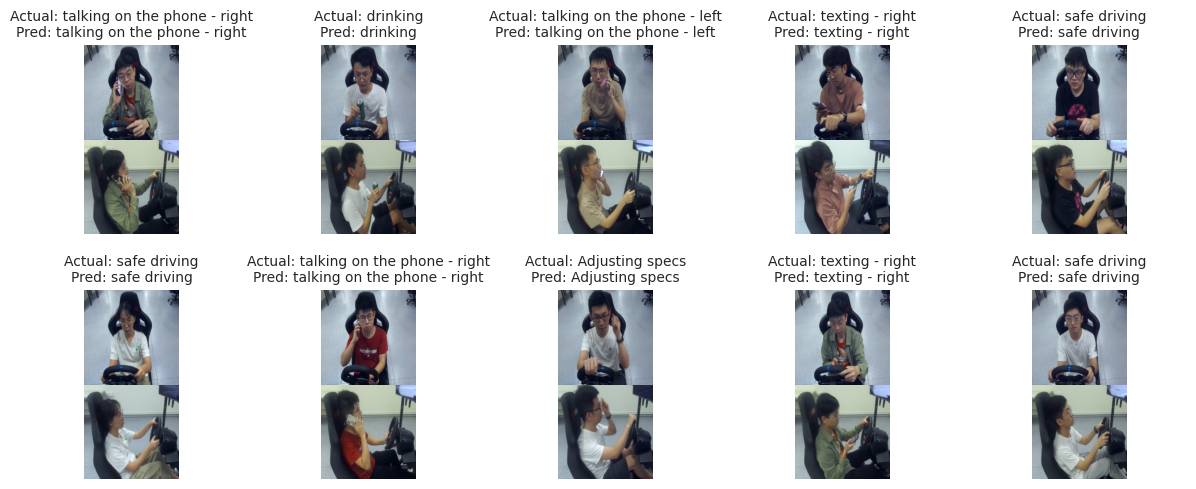

In [62]:
# Parameters for visualization
num_pairs_to_display = 10
images_to_display = []
images_per_row = 5  # 5 pairs per row, but each pair has 2 images


# Prepare the figure for visualization
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(int(np.ceil(num_pairs_to_display*2 / images_per_row)), images_per_row, figure=fig, hspace=0.3, wspace=0.1)


# Start the timer
start_time = time.time()

#Prediction phase
all_preds = []
all_true_labels = []
# Lists to collect data for visualization (indices or references)
data_for_visualization = []

model.eval()
with torch.no_grad():
    for i, (X1_test, X2_test, y_test) in enumerate(test_loader):
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(X1_test, X2_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        actual = y_test.cpu().numpy()
        all_true_labels.extend(actual)

        # Collect data for visualization
        for j in range(X1_test.size(0)):
          if len(data_for_visualization) < num_pairs_to_display:
              data_for_visualization.append((X1_test[j], X2_test[j], actual[j], preds[j]))
          else:
              break

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)

# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frame per second (FPS): {int(total_images/total_time)}")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

for i, (X1, X2, actual, pred) in enumerate(data_for_visualization):
    # Convert images to numpy for plotting
    image1 = X1.cpu().numpy().transpose((1, 2, 0))
    image2 = X2.cpu().numpy().transpose((1, 2, 0))

    # Normalize images for visualization
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())

    row = (i // images_per_row)
    col = i % images_per_row

    # Create a subplot for the pair
    ax_pair = plt.Subplot(fig, gs[row, col])
    fig.add_subplot(ax_pair)
    ax_pair.axis('off')

    # Create an inset axis for each image within the pair
    ax1 = ax_pair.inset_axes([0, 0.5, 1, 0.5])  # Top image
    ax2 = ax_pair.inset_axes([0, 0, 1, 0.5])  # Bottom image

    # Adjust the vertical spacing between the images in a pair
    ax1.set_title(f"Actual: {class_dict.get(actual, 'Unknown')}\nPred: {class_dict.get(pred, 'Unknown')}", fontsize=10)
    ax1.imshow(image1)
    ax1.axis('off')

    ax2.imshow(image2)
    ax2.axis('off')

plt.show()

In [64]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

result_path = os.path.join(log_path, 'model_predictions.csv')
metrics_path = os.path.join(log_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")

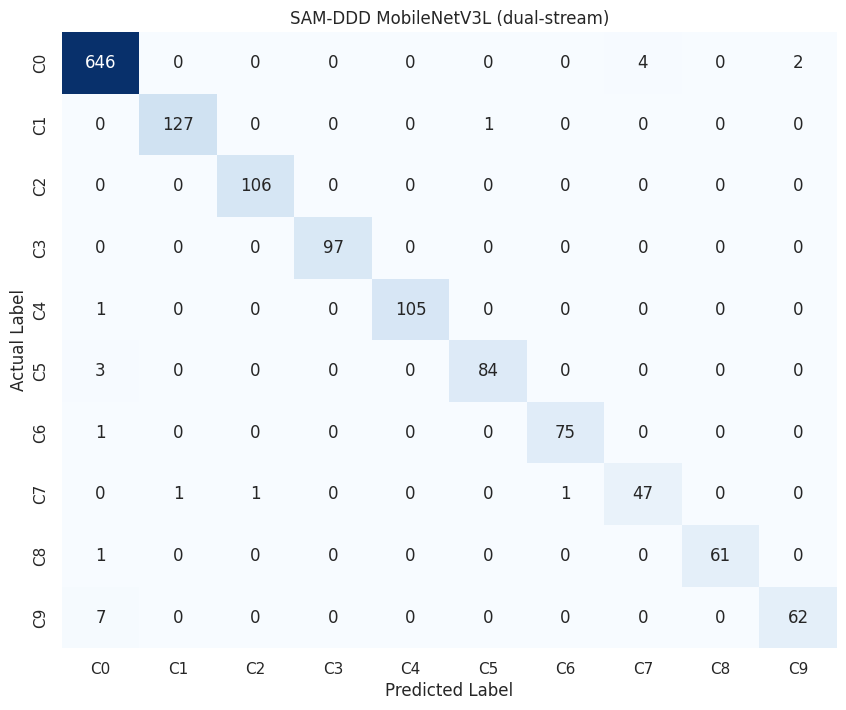

In [66]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)  # Adjust font size as needed
# Use seaborn's heatmap function to plot the confusion matrix
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('SAM-DDD MobileNetV3L (dual-stream)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [67]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(log_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)